In [1]:
import time
import numpy as np
import pandas as pd
import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep

import pickle as pkl
import sys
sys.path.insert(0,'..')
from models import ParticleNet
import torch
import torch.nn as nn
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.data import Data, Batch

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
%matplotlib inline

import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

import networkx as nx
import torch
import torch_geometric
import numpy as np
import pickle as pkl

## TEST TRAINING

In [2]:
! ls ./

ParticleNet_1     Roc_curve.pdf     particlenet.ipynb
ParticleNet_6     fastjet.ipynb     results.pdf
ParticleNet_model paper             xai_plots


In [108]:
# load the trained model
device = 'cpu'
PATH = "ParticleNet_6"
# PATH = "ParticleNet_1"

with open(f"{PATH}/model_kwargs.pkl", "rb") as f:
    model_kwargs = pkl.load(f)

state_dict = torch.load(f"{PATH}/best_epoch_weights.pth", map_location=device)

model = ParticleNet(**model_kwargs)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
test_data = torch.load("../data/toptagging/test/processed/data_0.pt")
loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [111]:
# all test data
data = []
for i in range(4):
    data = data + torch.load(f"../data/toptagging/test/processed/data_{i}.pt")
loader = DataLoader(data, batch_size=1, shuffle=True)

In [114]:
from tqdm.notebook import tqdm
sig = nn.Sigmoid()

y_score = None
y_test = None
for i, batch in tqdm(enumerate(loader)):
    preds, _, _, _ = model(batch)
    preds = sig(preds).detach()
    
    if y_score == None:
        y_score = preds[:].reshape(-1)
        y_test = batch.y
    else:
        y_score = torch.cat([y_score, preds[:].reshape(-1)])
        y_test = torch.cat([y_test, batch.y]) 
        
#     if i==10000:
#         break

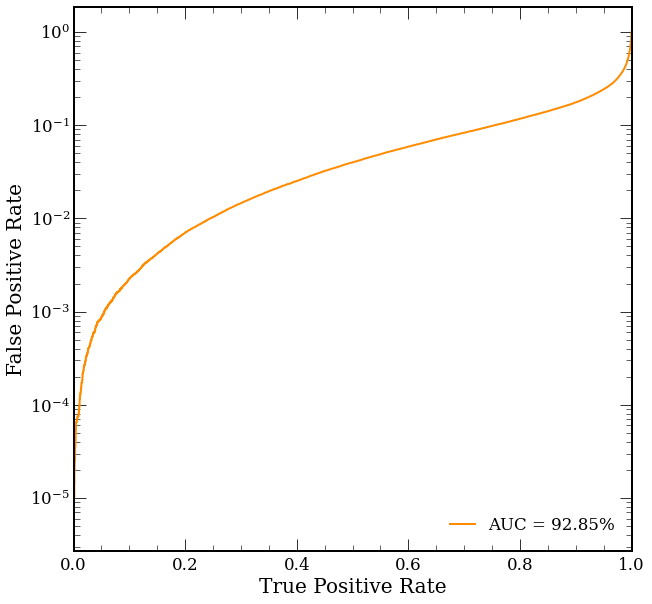

<Figure size 720x720 with 0 Axes>

In [120]:
# Compute ROC curve and ROC area for each class    
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
ax.plot(
    tpr,
    fpr,
    color="darkorange",
    lw=2,
    label=f"AUC = {round(auc(fpr, tpr)*100,2)}%",
)
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.yscale('log')
# plt.title("")
plt.legend(loc="lower right")
plt.show()
plt.savefig('Roc_curve.pdf');

# TEST LRP: dR and M_ij

In [128]:
def get_dr_Mij(trained=True):
    dr_top = []
    dr_qcd = []
    Mij_top = []
    Mij_qcd= []
        
    if trained:
        loops = 1    
    else:
        loops = 10
        
    for loop, models in enumerate(range(loops)):

        if trained:
            PATH = "ParticleNet_3/Rscores_best"
        else:
#             PATH = f"ParticleNet_6/Rscores_{loop}"
            PATH = f"ParticleNet_3/Rscores_0"

        with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
            batch_x_list = pkl.load(handle)
        with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
            batch_y_list = pkl.load(handle)

        with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
            R_edges_list = pkl.load(handle)    
        with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
            edge_index_list = pkl.load(handle)

        with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
            batch_px_list = pkl.load(handle)
        with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
            batch_py_list = pkl.load(handle)  
        with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
            batch_pz_list = pkl.load(handle)
        with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
            batch_E_list = pkl.load(handle)     

        for i in range(len(batch_y_list)):

            jet_label = batch_y_list[i]
            jet_input = batch_x_list[i]

            R_edges = R_edges_list[i]
            edge_index = edge_index_list[i]

#             if trained:        
            R_edges = R_edges['edge_conv_2']
            edge_index = edge_index['edge_conv_2']

            px = batch_px_list[i]
            py = batch_py_list[i]
            pz = batch_pz_list[i]
            e = batch_E_list[i]

            p = torch.sqrt(torch.square(px) + torch.square(py) + torch.square(pz))

            # recall: Features, in order: [eta, phi, pt, mask].
            eta = jet_input[:, 0]
            phi = jet_input[:, 1]
            pt = np.abs(jet_input[:, 2])

            eta_phi = jet_input[:, :2]

            # build graph
            edge_index, edge_weight = edge_index, torch.abs(R_edges).sum(axis=1)
            edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1

            def deltaR(eta1, eta2, phi1, phi2):
                return torch.sqrt(torch.square(eta2-eta1) + torch.square(phi2-phi1))

            top_5_edges = torch.topk(edge_Rscores, 5).indices   # pick top 5 edge Rscores, get the indices

            for edge in top_5_edges:
                particle_1 = edge_index[0][edge]
                particle_2 = edge_index[1][edge]

                px1 = px[particle_1]
                py1 = py[particle_1]
                pz1 = pz[particle_1]

                px2 = px[particle_2]
                py2 = py[particle_2]
                pz2 = pz[particle_2]

                eta1 = eta[particle_1]
                eta2 = eta[particle_2]

                phi1 = phi[particle_1]
                phi2 = phi[particle_2]

                e1 = e[particle_1]
                e2 = e[particle_2]

                M12 = torch.sqrt(torch.square(e1+e2) - torch.square(px1+ px2) - torch.square(py1+py2) - torch.square(pz1+pz2))

                if jet_label==1:
                    dr_top.append(deltaR(eta1, eta2, phi1, phi2).item())
                    Mij_top.append(M12)
                else:
                    dr_qcd.append(deltaR(eta1, eta2, phi1, phi2).item())
                    Mij_qcd.append(M12) 

    return dr_top, dr_qcd, Mij_top, Mij_qcd

## Make and save

In [129]:
dr_top_trained, dr_qcd_trained, Mij_top_trained, Mij_qcd_trained = get_dr_Mij(trained=True)
dr_top_untrained, dr_qcd_untrained, Mij_top_untrained, Mij_qcd_untrained = get_dr_Mij(trained=False)

import pickle as pkl

with open('paper/dr_top_trained.pkl', 'wb') as f:
    pkl.dump(dr_top_trained, f)
with open('paper/dr_qcd_trained.pkl', 'wb') as f:
    pkl.dump(dr_qcd_trained, f)
with open('paper/Mij_top_trained.pkl', 'wb') as f:
    pkl.dump(Mij_top_trained, f)
with open('paper/Mij_qcd_trained.pkl', 'wb') as f:
    pkl.dump(Mij_qcd_trained, f)
    
with open('paper/dr_top_untrained.pkl', 'wb') as f:
    pkl.dump(dr_top_untrained, f)
with open('paper/dr_qcd_untrained.pkl', 'wb') as f:
    pkl.dump(dr_qcd_untrained, f)
with open('paper/Mij_top_untrained.pkl', 'wb') as f:
    pkl.dump(Mij_top_untrained, f)
with open('paper/Mij_qcd_untrained.pkl', 'wb') as f:
    pkl.dump(Mij_qcd_untrained, f)    

## Load and plot

In [ ]:
# load the vars
with open('paper/dr_top_trained.pkl', 'rb') as f:
    dr_top_trained = pkl.load(f)
with open('paper/dr_qcd_trained.pkl', 'rb') as f:
    dr_qcd_trained = pkl.load(f)
with open('paper/Mij_top_trained.pkl', 'rb') as f:
    Mij_top_trained = pkl.load(f)
with open('paper/Mij_qcd_trained.pkl', 'rb') as f:
    Mij_qcd_trained = pkl.load(f)
    
with open('paper/dr_top_untrained.pkl', 'rb') as f:
    dr_top_untrained = pkl.load(f)
with open('paper/dr_qcd_untrained.pkl', 'rb') as f:
    dr_qcd_untrained = pkl.load(f)
with open('paper/Mij_top_untrained.pkl', 'rb') as f:
    Mij_top_untrained = pkl.load(f)
with open('paper/Mij_qcd_untrained.pkl', 'rb') as f:
    Mij_qcd_untrained = pkl.load(f) 

<ipython-input-130-1d06a60827b7>:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[0].set_ylim(0,20)
<ipython-input-130-1d06a60827b7>:22: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[1].set_ylim(0,20)


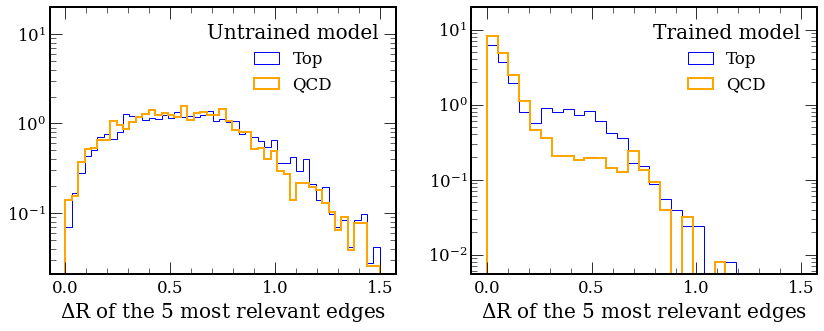

In [130]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
# font.set_family('serif')
font.set_name('Times New Roman')
# plt.rcParams.update({'font.family':'sans-serif'}) 
plt.rcParams.update({'font.family':'serif'}) 

# make the plot
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
axes[0].hist(dr_top_untrained, bins=np.linspace(0, 1.5, 50), label='Top', color="Blue", histtype='step', linewidth=1, density=True)
axes[0].hist(dr_qcd_untrained, bins=np.linspace(0, 1.5, 50), label='QCD', color="Orange", histtype='step', linewidth=2, density=True)
axes[0].legend(title='Untrained model')
axes[0].set_yscale('log') 
axes[0].set_ylim(0,20)
axes[0].set_xlabel('$\Delta$R of the 5 most relevant edges')

axes[1].hist(dr_top_trained, bins=np.linspace(0, 1.5, 30), label='Top', color="Blue",histtype='step', linewidth=1, density=True)
axes[1].hist(dr_qcd_trained, bins=np.linspace(0, 1.5, 30), label='QCD', color="Orange",   histtype='step', linewidth=2, density=True)
axes[1].legend(title='Trained model')
axes[1].set_yscale('log') 
axes[1].set_ylim(0,20)

axes[1].set_xlabel('$\Delta$R of the 5 most relevant edges')
fig.tight_layout()

plt.savefig('paper/deltaR.pdf')
plt.show()

<ipython-input-105-7e74385734da>:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[0].set_ylim(0,20)
<ipython-input-105-7e74385734da>:22: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[1].set_ylim(0,20)


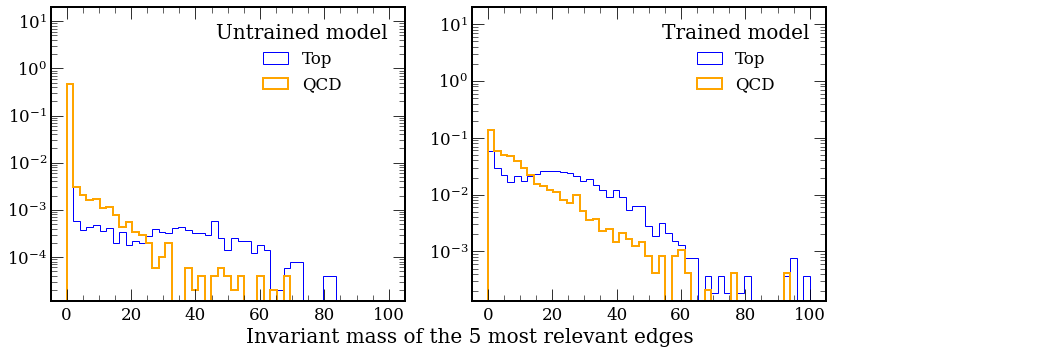

In [105]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
# font.set_family('serif')
font.set_name('Times New Roman')
# plt.rcParams.update({'font.family':'sans-serif'}) 
plt.rcParams.update({'font.family':'serif'}) 

# make the plot
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
axes[0].hist(Mij_top_untrained, bins=np.linspace(0, 100), label='Top', color="Blue", histtype='step', linewidth=1, density=True)
axes[0].hist(Mij_qcd_untrained, bins=np.linspace(0, 100), label='QCD', color="Orange", histtype='step', linewidth=2, density=True)
axes[0].legend(title='Untrained model')
axes[0].set_yscale('log') 
axes[0].set_ylim(0,20)
# axes[0].set_xlabel('Invariant mass of the 5 most relevant edges')

axes[1].hist(Mij_top_trained, bins=np.linspace(0, 100), label='Top', color="Blue",histtype='step', linewidth=1, density=True)
axes[1].hist(Mij_qcd_trained, bins=np.linspace(0, 100), label='QCD', color="Orange",   histtype='step', linewidth=2, density=True)
axes[1].legend(title='Trained model')
axes[1].set_yscale('log') 
axes[1].set_ylim(0,20)

# axes[1].set_xlabel('Invariant mass of the 5 most relevant edges')
fig.tight_layout()

plt.xlabel('Invariant mass of the 5 most relevant edges                                                        ')

plt.savefig('paper/Mij.pdf')
plt.show()

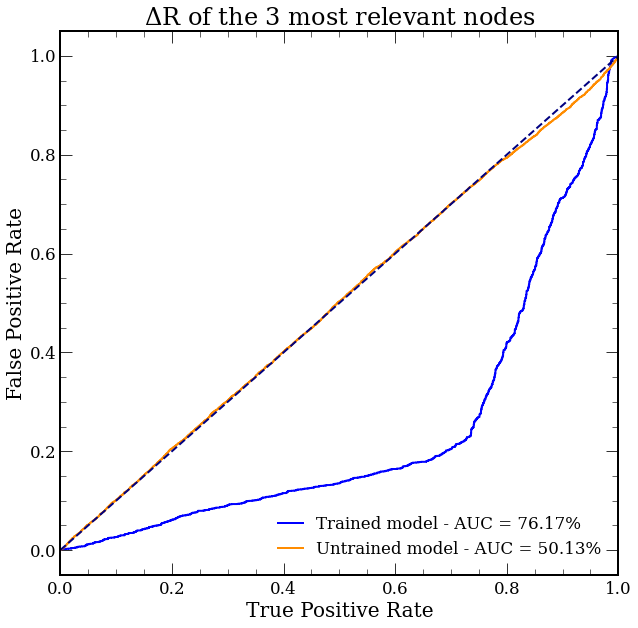

<Figure size 720x720 with 0 Axes>

In [119]:
# Compute ROC curve and ROC area for each class    

score = dr_top_trained + dr_qcd_trained
label = [1] * len(dr_top_trained) + [0] * len(dr_qcd_trained)
fpr_trained, tpr_trained, _ = roc_curve(label, score)
roc_auc = auc(fpr_trained, tpr_trained)

score = dr_top_untrained + dr_qcd_untrained
label = [1] * len(dr_top_untrained) + [0] * len(dr_qcd_untrained)
fpr_untrained, tpr_untrained, _ = roc_curve(label, score)
roc_auc_untrained = auc(fpr_untrained, tpr_untrained)

fig, ax = plt.subplots()
ax.plot(
    tpr_trained,
    fpr_trained,
    color="blue",
    lw=2,
    label=f"Trained model - AUC = {round(auc(fpr_trained, tpr_trained)*100,2)}%",
)
ax.plot(
    tpr_untrained,
    fpr_untrained,
    color="darkorange",
    lw=2,
    label=f"Untrained model - AUC = {round(auc(fpr_untrained, tpr_untrained)*100,2)}%",
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
# plt.yscale('log')
plt.title("$\Delta$R of the 3 most relevant nodes")
plt.legend(loc="lower right")
plt.show()
plt.savefig('Roc_curve.pdf');